In [1]:
from cheetah import Segment, ParticleBeam
import torch
import torch.nn as nn
import torch.nn.functional as F
import epics
import os
import numpy as np
import pprint
import h5py
from typing import List, Dict, Any, Callable
import yaml
import matplotlib.pyplot as plt
import math

In [2]:
import yaml
beam = ParticleBeam.from_twiss(
    beta_x=torch.tensor(9.34),
    alpha_x=torch.tensor(-1.6946),
    emittance_x=torch.tensor(1e-7),
    beta_y=torch.tensor(9.34),
    alpha_y=torch.tensor(-1.6946),
    emittance_y=torch.tensor(1e-7),
    energy=torch.tensor(90e6),
    num_particles=10000,
    total_charge=torch.tensor(1e-9)
)
print(os.getcwd())
segment = Segment.from_lattice_json("../lattices/diag0.json")


/Users/cgarnier/Desktop/sim/Linac-Simulation-Server/notebooks


In [3]:
centroids_x_fit = torch.tensor([1149.3820281 , 1075.83305578, 1002.28408347,  928.73511115,
        855.18613884,  781.63716653,  734.61318163,  754.34669809,
        774.08021455,  793.81373101])
phase_stack = torch.tensor([31.32, 32.46111111, 33.54222222, 34.65333333, 35.79444444, 36.57555556, 37.59666667, 38.76777778,
                            39.87888889, 40.93])
centroid_stack = torch.tensor([[828.08930673, 916.90077404],
 [818.34351269, 915.30759782],
 [807.56969297, 916.28401422],
 [793.69595668, 915.02744222],
 [779.83461336, 917.25265671],
 [769.61706806, 917.46267198],
 [754.57756747, 914.9925416 ],
 [739.4957848, 912.41477866],
 [729.42872929, 914.46341265],
 [718.79783602, 913.04128056]])

print(phase_stack)
phase_stack = phase_stack * (math.pi/180)
phase_stack[2]

tensor([31.3200, 32.4611, 33.5422, 34.6533, 35.7944, 36.5756, 37.5967, 38.7678,
        39.8789, 40.9300])


tensor(0.5854)

tensor(0.5466)
None
tensor(0.5666)
None
tensor(0.5854)
None
tensor(0.6048)
None
tensor(0.6247)
None
tensor(0.6384)
None
tensor(0.6562)
None
tensor(0.6766)
None
tensor(0.6960)
None
tensor(0.7144)
None


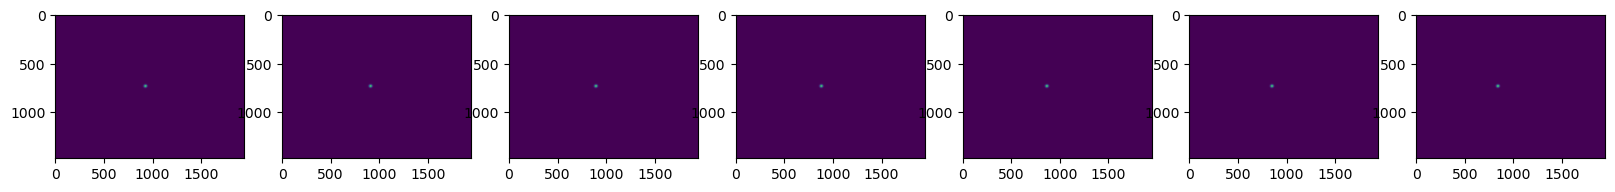

In [4]:
import matplotlib.pyplot as plt
otr2_data = []
otr4_data = []
#problem with the angle... or ??? the rf is oscillating too fast.
mu_x = []
mu_y = []
for i in range(len(phase_stack)):
    print(phase_stack[i])
    segment.tcxdg0.voltage = torch.tensor(.135e6)
    segment.tcxdg0.phase = phase_stack[i] 
    tracked_beam = segment.track(beam) 
    otr2_data.append(segment.otrdg02.reading) #property for location of all the pixels in meters, ax.pcolor plots in meters not pixels
    mu_x.append(tracked_beam.mu_x) #this at the end of segment not otrdg02
    mu_y.append(tracked_beam.mu_y)

# this is in meters not pixels -> conversion factor
mu_X=torch.tensor(mu_x)

fig, axs = plt.subplots(1, 7, figsize=(20, 10))  # 1 row, 7 columns
for i in range(7):
    axs[i].imshow(otr2_data[i])
    #color mesh

In [5]:
names = [element.name for element in segment.elements]
ind = names.index('otrdg02')
ind2 = names.index('tcxdg0')
print(f'index number {ind2}')
front_segment = Segment(
    elements=segment.elements[:ind+1],
)
front_segment.tcxdg0.phase = phase_stack
tracked_beam =front_segment.track(beam) 
otr2_data = front_segment.otrdg02.reading #property for location of all the pixels in meters, ax.pcolor plots in meters not pixels
mu_x = tracked_beam.mu_x #this at the end of segment not otrdg02
mu_y = tracked_beam.mu_y

print(front_segment.otrdg02.extent)

index number 178
None
tensor([-0.0226,  0.0226, -0.0171,  0.0171])


In [6]:
otr2_data.shape
print(mu_x.shape)
print(mu_y.shape)

torch.Size([10])
torch.Size([10])


In [7]:
def meters_to_pixel(offsets_in_meters:torch.tensor, screen_resolution: float, pixels_in_axis: int):
    offset_in_pixels = offsets_in_meters/ screen_resolution
    pixels =pixels_in_axis/2 + offset_in_pixels
    return pixels

def meters_to_pixel(se)

In [8]:
#plot tragectories, might have to specify an index for batched objects
#front_segment.plot_overview(beam,vector_idx=[0])
#pretty sure there is a problem with mu_x? its beam position in meters but with respect to what?? 
# once I get this I can optimize without PVs will do this both ways, optimize with the server and with PVs
mu_X=torch.tensor(mu_x)

mu_X_pixels = meters_to_pixel(mu_X, 23.33e-6, 1944)
print(f'mu_X: {mu_X}')
print(f'mu_X: {mu_X_pixels}')


mu_X: tensor([-0.0011, -0.0015, -0.0019, -0.0023, -0.0026, -0.0029, -0.0031, -0.0034,
        -0.0035, -0.0037])
mu_X: tensor([925.5709, 906.7316, 889.8198, 873.6429, 858.5493, 849.2271, 838.4078,
        828.0664, 820.4440, 815.3002])


/var/folders/vz/n3kzmhb11kl0lb9jv7prt8r9gymfby/T/ipykernel_32851/2979226617.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu_X=torch.tensor(mu_x)


In [9]:
from scipy.optimize import curve_fit
X = phase_stack.detach().cpu().numpy()
Y = centroid_stack.detach().cpu().numpy()
# 1. Linear fit for centroid X
def linear(x, m, b):
    return m * x + b

params_x, _ = curve_fit(linear, X, Y[:, 0])
fit_x = linear(X, *params_x)

Y_sim = mu_X_pixels.detach().cpu().numpy()
params_sim, _ = curve_fit(linear, X, Y_sim)
fit_sim = linear(X, *params_sim)

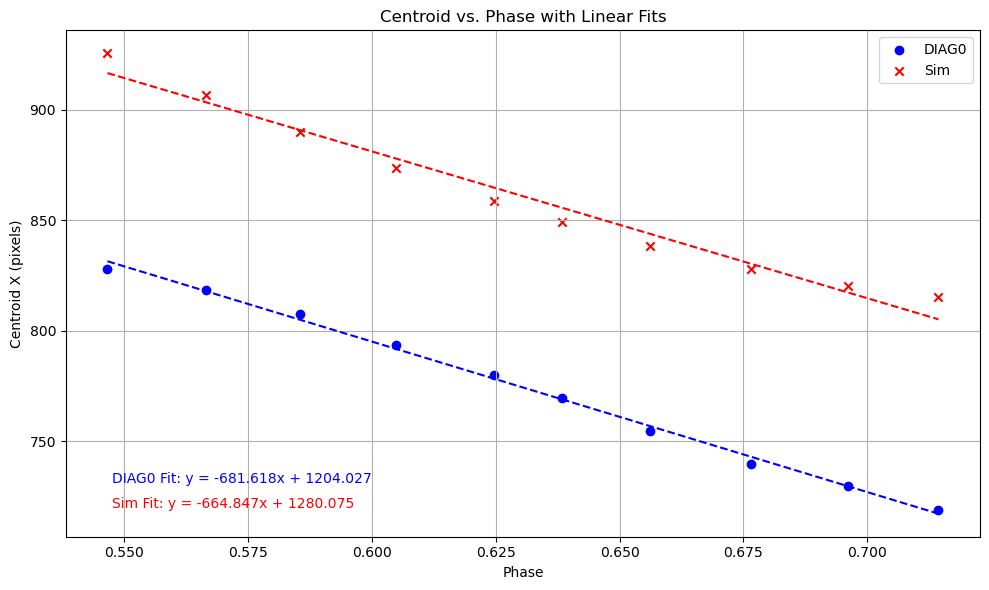

In [10]:
# Start plot
plt.figure(figsize=(10, 6))

# Scatter 1
plt.scatter(phase_stack, centroid_stack[:,0], color='blue', label='DIAG0', marker='o')

# Scatter 2
plt.scatter(phase_stack, mu_X_pixels, color='red', label='Sim', marker='x')

# Line 1
plt.plot(phase_stack, fit_x, color='blue', linestyle='--')
plt.plot(phase_stack, fit_sim, color='red', linestyle='--')

# Extract fit parameters
m1, b1 = params_x
m2, b2 = params_sim

plt.text(0.05, 0.10, f'DIAG0 Fit: y = {m1:.3f}x + {b1:.3f}', transform=plt.gca().transAxes,
         color='blue', fontsize=10, verticalalignment='bottom')
plt.text(0.05, 0.05, f'Sim Fit: y = {m2:.3f}x + {b2:.3f}', transform=plt.gca().transAxes,
         color='red', fontsize=10, verticalalignment='bottom')

# Labels and legend
plt.xlabel('Phase')
plt.ylabel('Centroid X (pixels)')
plt.legend()
plt.title('Centroid vs. Phase with Linear Fits')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
#create model that takes front segment,
def centroid_calculation(A, phase, c, b):
    print(phase)
    print(front_segment.tcxdg0.voltage)
    print(A)
    front_segment.tcxdg0.voltage = torch.tensor(A, requires_grad= True)
    front_segment.tcxdg0.phase = phase # vectorized phase tensor
    tracked_beam =front_segment.track(beam) 
    mu_x = tracked_beam.mu_x
    print(mu_x)
    mu_X_pixels = meters_to_pixel(mu_x, 23.33e-6, 1944)
    print(mu_X_pixels)
    return mu_X_pixels

In [12]:
def gradient_descent(X0, function, alpha=0.1, n_iterations=100):
    """
    Performs 100 iterations of gradient descent
    
    Inputs:
    X0: a pytorch tensor to be modified in-place by the gradient descent algorithm
    function: a callable, that takes X0 as input
    alpha: step size for the gradient descent algorithm
    n_iterations: number of iterations of gradient descent
    
    Returns:
    history_X: array of values of X
    history_f: array of values of f
    """
    history_X = []
    history_f = []
    for iteration in range(n_iterations): # iterations of gradient descent
        f = function(X0)
        
        f.backward()
        with torch.no_grad():
            X0 -= alpha*X0.grad
        X0.grad.zero_()
        
        # Keep a copy in history (do not modify these lines)
        history_X.append( X0.detach().numpy().copy() ) 
        history_f.append( f.detach().numpy().copy() )
        
    return np.array(history_X), np.array(history_f)


In [13]:
#centroids = centroid_calculation(.31e6, phase_stack, 0, 0)
#print(centroids)
#centroids.backward()
num_steps= 2500

In [14]:
def train(num_steps: int, lr=1500) -> dict:
    beam_parameter_history = []
    tcav_setting_history = []
    loss_history = []
    #parameter= nn.Parameter(front_segment.tcxdg0.voltage)
    #optimizer = torch.optim.Adam(parameter, lr=lr)
    parameter = nn.Parameter(front_segment.tcxdg0.voltage.clone().detach(), requires_grad=True)
    optimizer = torch.optim.Adam([parameter], lr=lr)
    for _ in range(num_steps):
        optimizer.zero_grad()
        #print(parameter)
        front_segment.tcxdg0.voltage = parameter
        front_segment.tcxdg0.phase = phase_stack # vectorized phase tensor
        tracked_beam =front_segment.track(beam) 
        mu_x = tracked_beam.mu_x
        mu_X_pixels = meters_to_pixel(mu_x, 23.33e-6, 1944)


        loss = F.mse_loss(centroid_stack[:,0], mu_X_pixels)

        loss.backward()

        # Log magnet settings and beam parameters
        loss_history.append(loss.item())
        beam_parameter_history.append(mu_X_pixels.detach().numpy())
        tcav_setting_history.append(front_segment.tcxdg0.voltage.clone().detach().numpy()
        )
        optimizer.step()

    history = {
        "loss": loss_history,
        "beam_parameters": beam_parameter_history,
        "tcav_settings": tcav_setting_history,
    }
    return history
num_steps= 100
history = train(num_steps=num_steps)

# can try and mock centroids as c = (a*voltage)*phase + b

In [15]:
#print(history)
print(history['loss'][-20:-1])
print(history['loss'][-1])
#previous best 744.15
# need to brain storm better ways to reduce loss
print(history['tcav_settings'][-1])
# best fit at 230,030.27 when we know that 300,000 is what was used in experiment
# maybe some other learnable paramters ?  set voltage to 3MV and learn a, b
# # can try and mock centroids as c = (a*voltage)*phase + b

[812.228515625, 806.280517578125, 800.7975463867188, 795.7478637695312, 791.1045532226562, 786.8394775390625, 782.9263916015625, 779.3408203125, 776.0615234375, 773.0645141601562, 770.3299560546875, 767.8390502929688, 765.5721435546875, 763.5130615234375, 761.64501953125, 759.9539794921875, 758.4237670898438, 757.0432739257812, 755.7989501953125]
754.6798095703125
226810.06


In [16]:
history['beam_parameters'][-1]

array([894.00244, 862.35095, 833.93787, 806.7596 , 781.40106, 765.7391 ,
       747.5619 , 730.18756, 717.3815 , 708.7395 ], dtype=float32)

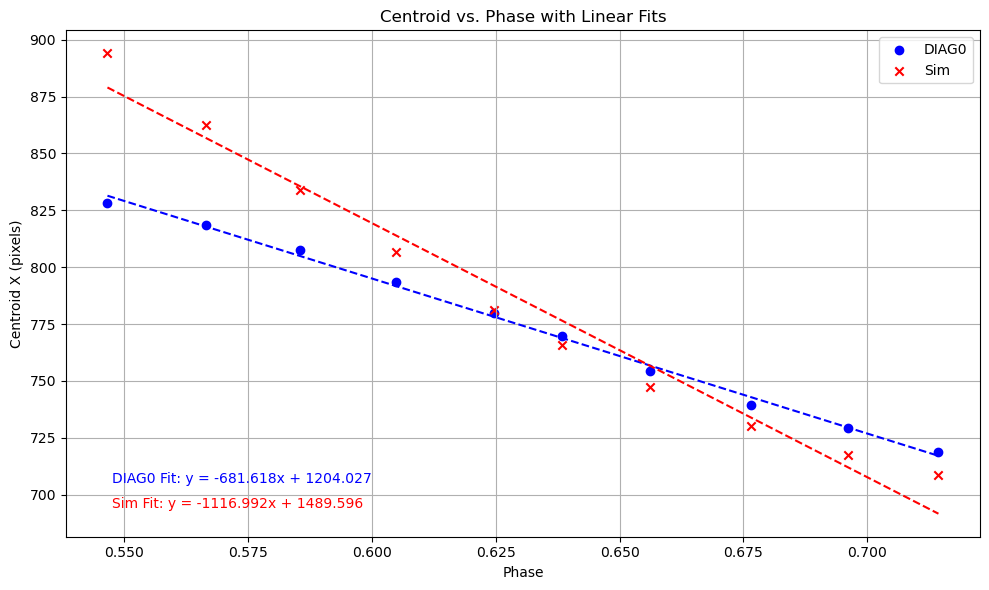

In [17]:
from scipy.optimize import curve_fit
X = phase_stack.detach().cpu().numpy()
Y = centroid_stack.detach().cpu().numpy()
# 1. Linear fit for centroid X
def linear(x, m, b):
    return m * x + b

params_x, _ = curve_fit(linear, X, Y[:, 0])
fit_x = linear(X, *params_x)

Y_sim = np.array(history['beam_parameters'][-1])
params_sim, _ = curve_fit(linear, X, Y_sim)
fit_sim = linear(X, *params_sim)# Start plot
plt.figure(figsize=(10, 6))

# Scatter 1
plt.scatter(phase_stack, centroid_stack[:,0], color='blue', label='DIAG0', marker='o')

# Scatter 2
plt.scatter(phase_stack, history['beam_parameters'][-1], color='red', label='Sim', marker='x')

# Line 1
plt.plot(phase_stack, fit_x, color='blue', linestyle='--')
plt.plot(phase_stack, fit_sim, color='red', linestyle='--')

# Extract fit parameters
m1, b1 = params_x
m2, b2 = params_sim

plt.text(0.05, 0.10, f'DIAG0 Fit: y = {m1:.3f}x + {b1:.3f}', transform=plt.gca().transAxes,
         color='blue', fontsize=10, verticalalignment='bottom')
plt.text(0.05, 0.05, f'Sim Fit: y = {m2:.3f}x + {b2:.3f}', transform=plt.gca().transAxes,
         color='red', fontsize=10, verticalalignment='bottom')

# Labels and legend
plt.xlabel('Phase')
plt.ylabel('Centroid X (pixels)')
plt.legend()
plt.title('Centroid vs. Phase with Linear Fits')
plt.grid(True)
plt.tight_layout()
plt.show()

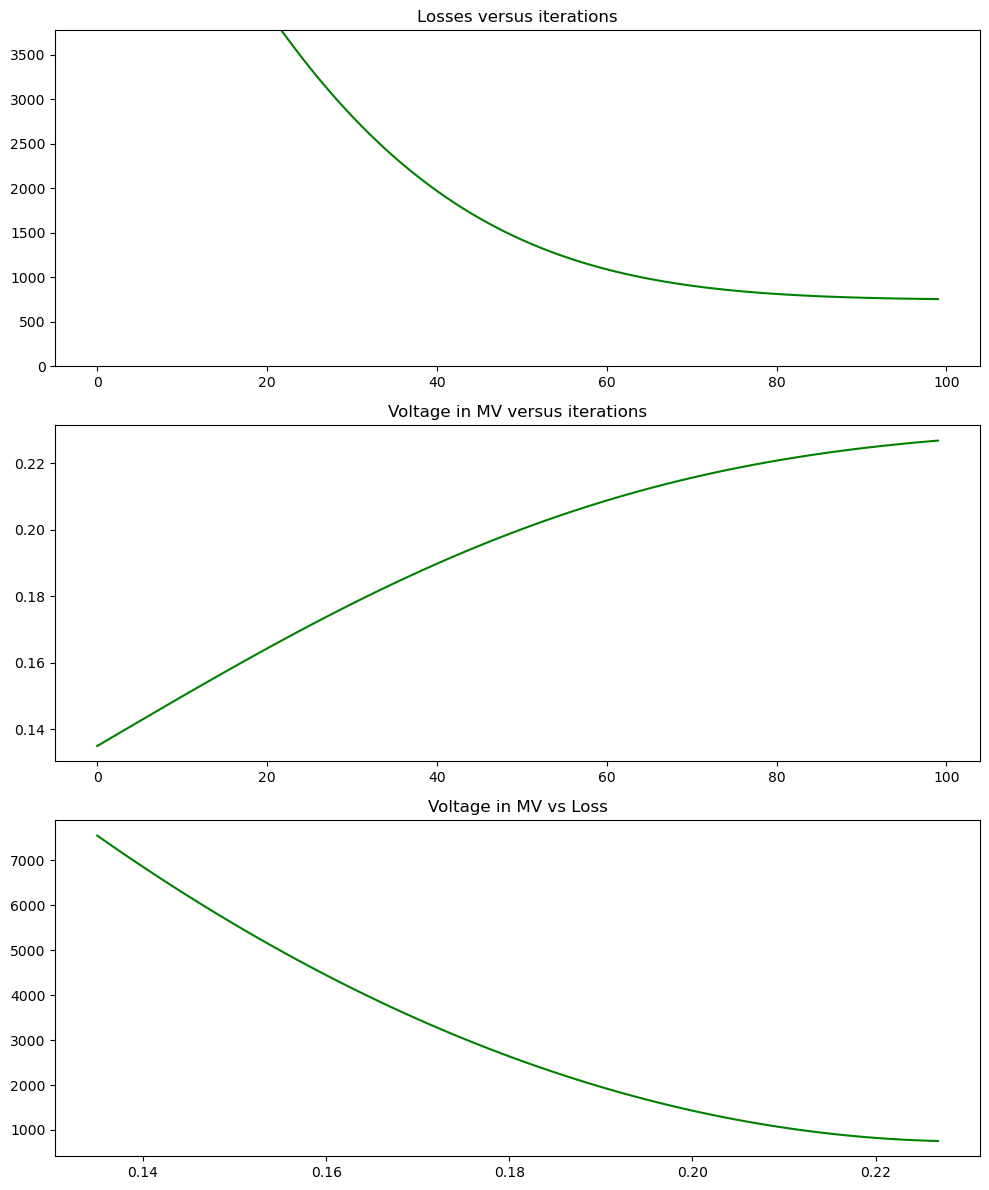

In [18]:
iteration= np.arange(0,num_steps,1)
fig, axes = plt.subplots(3,1, figsize = (10,12))
axes[0].plot(iteration, np.array(history['loss']), color = 'green', label = 'Losses versus iterations' )
axes[0].set_ylim(0 * 0.95, np.array(history['loss']).max() * .5)
axes[0].set_title('Losses versus iterations')
axes[1].plot(iteration, np.array(history['tcav_settings'])/1e6, color = 'green', label = 'TCAV in MV versus iterations' )
axes[1].set_title('Voltage in MV versus iterations')
axes[2].plot(np.array(history['tcav_settings'])/1e6,  np.array(history['loss']), color = 'green', label = 'TCAV in MV versus Loss' )
axes[2].set_title('Voltage in MV vs Loss')
plt.tight_layout()
plt.show()

In [ ]:
# Remove the parameter registration (set to None first)
front_segment.tcxdg0.register_parameter("voltage", None)
del front_segment.tcxdg0.voltage
# Now you can assign a plain tensor
front_segment.tcxdg0.voltage = torch.tensor(0.0)
front_segment.tcxdg0.phase  = torch.tensor(0.0)


In [ ]:
tracked_beam = front_segment.track(beam)
front_segment.otrdg02.reading